In [9]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
import PTMCMCSampler

from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
import sys
sys.path.append("../modules")
import models as lncass_models
from lncass import PRIOR_DICT
from transformations import simple_dict_transformation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
maindir = '../../../repositories/discovery'
Npsrs = 30
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/data/*-[JB]*.feather'))]
psrn_unsorted = [psr.name for psr in psrs]
psrnames_sorted = np.loadtxt("../misc/psrnames_pbf_sorted.txt", dtype=str)[:Npsrs]
psrs = [psrs[psrn_unsorted.index(psr)] for psr in psrnames_sorted]
print([psr.name for psr in psrs])
Tspan_pta = ds.getspan(psrs)
names = [psr.name for psr in psrs]
n_rn_freqs = 30

['J1909-3744', 'J1918-0642', 'J1832-0836', 'J1614-2230', 'J2010-1323', 'J0645+5158', 'J1853+1303', 'J1600-3053', 'J1738+0333', 'J1910+1256', 'J1640+2224', 'J1730-2304', 'J1944+0907', 'J1741+1351', 'J2214+3000', 'J1923+2515', 'J2229+2643', 'J2145-0750', 'J2322+2057', 'J1024-0719', 'J2017+0603', 'J0740+6620', 'J2033+1734', 'B1953+29', 'J0023+0923', 'J2317+1439', 'J0406+3039', 'J1946+3417', 'J0340+4130', 'J1125+7819']


In [5]:
def makefreespec_crn(components):
    if ds.matrix.jnp == jnp:
        def freespec_crn(f, df, log10_rho, crn_log10_rho):
            phi = jnp.repeat(10.0**(2.0 * log10_rho), 2)
            phi = phi.at[:2*components].add(jnp.repeat(10.0**(2.0 * crn_log10_rho), 2))
            return phi
    elif ds.matrix.jnp == np:
        def freespec_crn(f, df, log10_rho, crn_log10_rho):
            phi = jnp.repeat(10.0**(2.0 * log10_rho), 2)
            phi[:2*components] += jnp.repeat(10.0**(2.0 * crn_log10_rho), 2)
            return phi
    return freespec_crn

m2 = ds.ArrayLikelihood((ds.PulsarLikelihood([psr.residuals,
                                                    ds.makenoise_measurement(psr, psr.noisedict),
                                                    ds.makegp_ecorr(psr, psr.noisedict),
                                                    ds.makegp_timing(psr, svd=True, constant=1e-6)]) for psr in psrs),
                              ds.makecommongp_fourier(psrs, makefreespec_crn(n_rn_freqs), n_rn_freqs, T=Tspan_pta, common=['crn_log10_rho'], name='red_noise'))

In [14]:
model, gl = lncass_models.create_rn_pta_model(psrs, n_rn_freqs, array=True)

In [15]:
fspec_untransformed_parameter_example = np.array([np.random.rand(30) * 5 - 9 for ii in range(np.size(gl.logL.params))])
tmp = {f'{psrname}_red_noise_log10_rho(30)': fspec_untransformed_parameter_example[ii, :] for ii, psrname in enumerate(sorted(psrnames_sorted))}
tmp['crn_log10_rho(30)'] = fspec_untransformed_parameter_example[-1, :]

In [16]:
transformed_ll = simple_dict_transformation(gl.logL)

In [17]:
jit_ll = jax.jit(gl.logL)
jit_ll_transform = jax.jit(transformed_ll)
print(jit_ll(tmp))
print(jit_ll_transform(fspec_untransformed_parameter_example))

3972210.086341564
3972210.086341564


In [18]:
%timeit jit_ll(tmp)

1.55 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit jit_ll_transform(fspec_untransformed_parameter_example)

258 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
full_pta_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=10),
    num_warmup=1000,
    num_samples=500,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [23]:
with numpyro.validation_enabled():
    full_pta_sampler.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT, 'sigma_lambda': dist.Uniform(4.999, 5.001), 'mu_lambda': dist.Uniform(-0.001, 0.001)})

sample: 100%|██████████| 1500/1500 [41:17<00:00,  1.65s/it, 1023 steps of size 1.55e-03. acc. prob=0.80]


In [24]:
full_pta_sampler.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
        beta_xi_o[0,0]     -0.06      0.93     -0.07     -1.60      1.42     59.47      1.00
        beta_xi_o[0,1]      0.00      0.98     -0.06     -1.45      1.80     41.08      1.03
        beta_xi_o[0,2]     -0.12      0.92     -0.18     -1.63      1.22     53.90      1.04
        beta_xi_o[0,3]      0.07      0.85      0.14     -1.17      1.57     83.30      1.00
        beta_xi_o[0,4]     -0.21      0.91     -0.21     -1.67      1.17     64.05      1.00
        beta_xi_o[0,5]     -0.11      0.92     -0.05     -1.41      1.43     58.48      1.00
        beta_xi_o[0,6]     -0.11      0.99     -0.05     -1.76      1.38     80.74      1.01
        beta_xi_o[0,7]     -0.07      0.92     -0.13     -1.52      1.46     74.93      1.00
        beta_xi_o[0,8]     -0.04      1.00      0.02     -1.82      1.43     64.60      1.07
        beta_xi_o[0,9]     -0.28      0.96     -0.31     -1.92      1

In [25]:
samples = full_pta_sampler.get_samples()

In [26]:
samples['log10_rho'].shape

(500, 30, 31)

[autoreload of models failed: Traceback (most recent call last):
  File "/central/groups/LFGW/meyers/mambaforge/envs/meyers/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/central/groups/LFGW/meyers/mambaforge/envs/meyers/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/central/groups/LFGW/meyers/mambaforge/envs/meyers/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/central/home/pmeyers/projects/flexible_pta_spectr

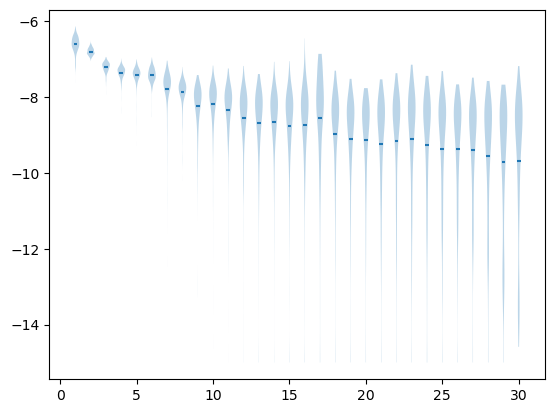

In [29]:
plt.violinplot(samples['log10_rho'][:, :, -1].T, showmeans=True, showextrema=False)
plt.show()

# Free Spec GW, RN Power law

In [30]:
fspec_gw_model, gl_plrn_fsgw = lncass_models.create_pta_model_plrn_fsgw(psrs, n_rn_freqs)

In [35]:
gl_plrn_fsgw.logL.params

['B1953+29_red_noise_gamma',
 'B1953+29_red_noise_log10_A',
 'J0023+0923_red_noise_gamma',
 'J0023+0923_red_noise_log10_A',
 'J0340+4130_red_noise_gamma',
 'J0340+4130_red_noise_log10_A',
 'J0406+3039_red_noise_gamma',
 'J0406+3039_red_noise_log10_A',
 'J0645+5158_red_noise_gamma',
 'J0645+5158_red_noise_log10_A',
 'J0740+6620_red_noise_gamma',
 'J0740+6620_red_noise_log10_A',
 'J1024-0719_red_noise_gamma',
 'J1024-0719_red_noise_log10_A',
 'J1125+7819_red_noise_gamma',
 'J1125+7819_red_noise_log10_A',
 'J1600-3053_red_noise_gamma',
 'J1600-3053_red_noise_log10_A',
 'J1614-2230_red_noise_gamma',
 'J1614-2230_red_noise_log10_A',
 'J1640+2224_red_noise_gamma',
 'J1640+2224_red_noise_log10_A',
 'J1730-2304_red_noise_gamma',
 'J1730-2304_red_noise_log10_A',
 'J1738+0333_red_noise_gamma',
 'J1738+0333_red_noise_log10_A',
 'J1741+1351_red_noise_gamma',
 'J1741+1351_red_noise_log10_A',
 'J1832-0836_red_noise_gamma',
 'J1832-0836_red_noise_log10_A',
 'J1853+1303_red_noise_gamma',
 'J1853+1303_

In [34]:
logL = simple_dict_transformation(gl_plrn_fsgw.logL)
logL

In [31]:
full_pta_plrn_fsgw = infer.MCMC(
    infer.NUTS(fspec_gw_model, max_tree_depth=7),
    num_warmup=1000,
    num_samples=500,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [32]:
with numpyro.validation_enabled():
    full_pta_plrn_fsgw.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT, 'sigma_lambda': dist.Uniform(4.999, 5.001), 'mu_lambda': dist.Uniform(-0.001, 0.001)})

warmup:   1%|          | 12/1500 [00:24<50:54,  2.05s/it, 127 steps of size 2.21e-02. acc. prob=0.64]


KeyboardInterrupt: 

In [20]:
samples_plrn_fsgw = full_pta_plrn_fsgw.get_samples()

# PL GW, PL RN

In [55]:
pl_gw_model, gl_pl_gw = lncass_models.create_pta_model_plrn_plgw(psrs, n_rn_freqs)

In [56]:
type(gl_pl_gw)

discovery.likelihood.ArrayLikelihood

In [70]:
full_pta_plrn_plgw = infer.MCMC(
    infer.NUTS(pl_gw_model, max_tree_depth=10),
    num_warmup=1000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [71]:
with numpyro.validation_enabled():
    full_pta_plrn_plgw.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT, 'sigma_lambda': dist.Uniform(4.999, 5.001), 'mu_lambda': dist.Uniform(-0.001, 0.001)})

sample: 100%|██████████| 2000/2000 [03:10<00:00, 10.52it/s, 63 steps of size 6.53e-02. acc. prob=0.91] 


In [72]:
samples_plrn_plgw = full_pta_plrn_plgw.get_samples()

In [73]:
full_pta_plrn_plgw.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
     log10_A_rn[0]    -12.93      0.24    -12.90    -13.30    -12.51    693.55      1.00
     log10_A_rn[1]    -16.87      1.93    -17.02    -19.97    -14.00    609.58      1.00
     log10_A_rn[2]    -16.98      1.82    -16.99    -20.00    -14.49    786.65      1.00
     log10_A_rn[3]    -16.25      2.02    -16.18    -19.49    -13.25    761.58      1.00
     log10_A_rn[4]    -15.85      2.32    -15.56    -19.29    -12.99    231.86      1.02
     log10_A_rn[5]    -17.09      1.74    -17.16    -19.95    -14.58    932.04      1.00
     log10_A_rn[6]    -16.88      1.89    -16.91    -19.99    -14.21    745.07      1.01
     log10_A_rn[7]    -16.86      1.93    -17.09    -20.00    -14.14    747.65      1.00
     log10_A_rn[8]    -16.82      1.88    -16.90    -19.48    -13.51    716.59      1.00
     log10_A_rn[9]    -17.08      1.75    -17.15    -19.84    -14.51    754.65      1.00
    log10_A_rn[10]  

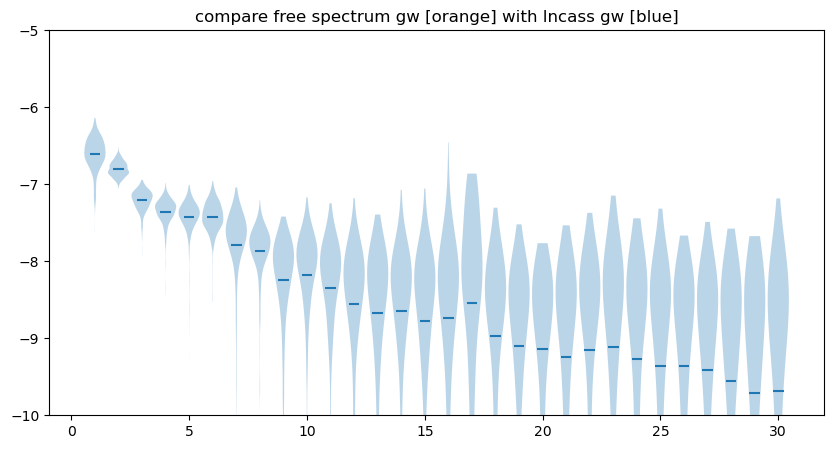

In [64]:
plt.figure(figsize=(10, 5))
plt.title("compare free spectrum gw [orange] with lncass gw [blue]")
plt.violinplot(samples['log10_rho'][:, :, -1].T, showmeans=True, showextrema=False, widths=0.9)
# plt.violinplot(samples_plrn_plgw['log10_rho_gw'], showmeans=True, showextrema=False, widths=0.9)
plt.ylim(-10, -5)
plt.show()

In [74]:
rhos_pl = []
freqs = np.arange(1, n_rn_freqs + 1) / Tspan_pta
fyr = 1 / 86400 / 365.25
for ii in range(500):
    idx = np.random.randint(0, 500)
    log10_A = samples_plrn_plgw['log10_A_rn'][idx, -1]
    gamma = samples_plrn_plgw['log10_gamma_rn'][idx, -1]
    rhos_pl.append(jnp.log10(10**(2*log10_A) / (12 * np.pi**2) * (freqs / fyr)**(-gamma) * fyr**-3 / Tspan_pta) / 2)
    
rhos_pl = np.array(rhos_pl)

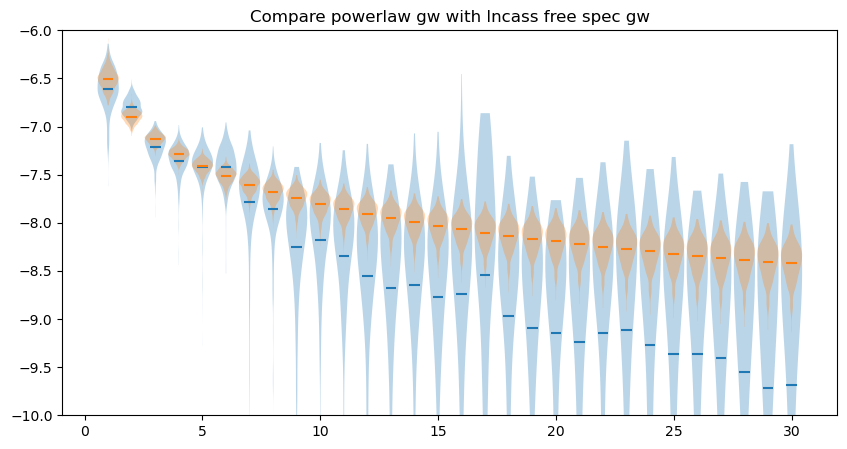

In [75]:

plt.figure(figsize=(10, 5))
plt.title("Compare powerlaw gw with lncass free spec gw")
plt.violinplot(samples['log10_rho'][:, :, -1].T, showmeans=True, showextrema=False, widths=0.9)
plt.violinplot(rhos_pl, showmeans=True, showextrema=False,  widths=0.9)
plt.ylim(-10, -6)
plt.show()

# Compare PL red noise with lncass red noise

TypeError: Axes.violinplot() got an unexpected keyword argument 'side'

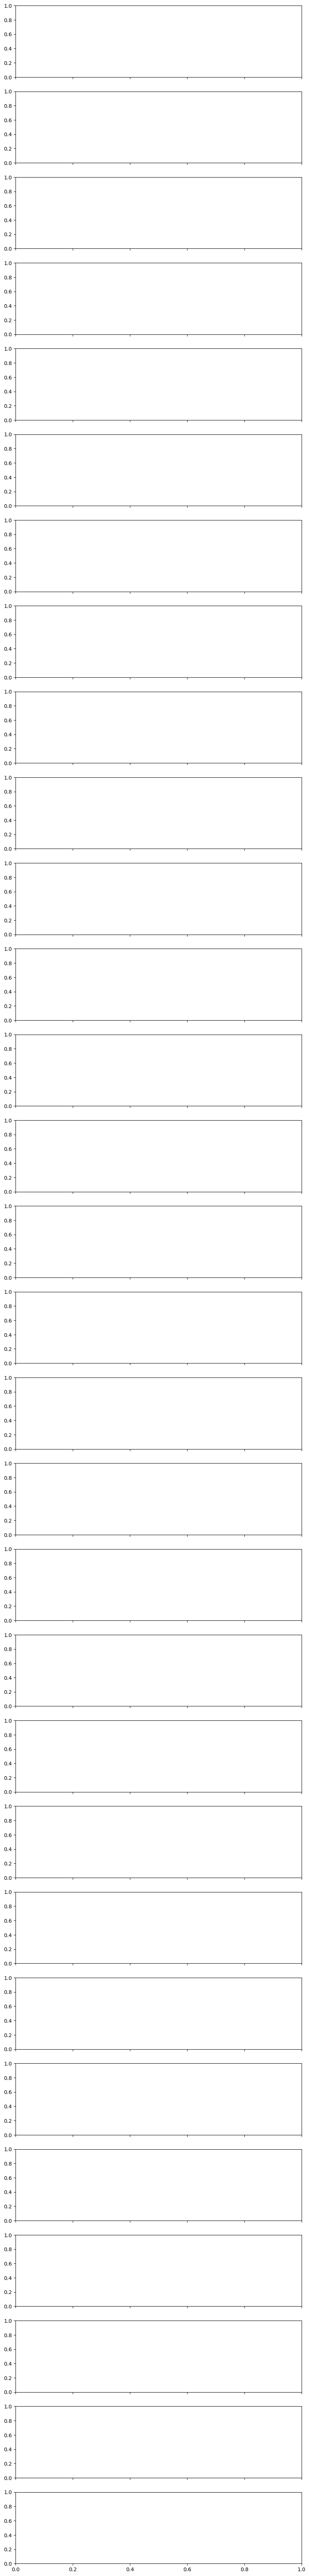

In [76]:
fig, ax = plt.subplots(Npsrs, 1, sharex=True, figsize=(10, 3 * Npsrs))
for ii, psrname in enumerate(psrnames_sorted):
    ax[ii].violinplot(samples['log10_rho'][:, :, ii], showmeans=True, showextrema=False, side='low', widths=0.9)
    ax[ii].set_title(psrname)
    rhos_pl = []
    for kk in range(500):
        idx = np.random.randint(0, 500)
        log10_A = samples_plrn_plgw['log10_A_rn'][idx, ii]
        gamma = samples_plrn_plgw['log10_gamma_rn'][idx, ii]
        rhos_pl.append(jnp.log10(10**(2*log10_A) / (12 * np.pi**2) * (freqs / fyr)**(-gamma) * fyr**-3 / Tspan_pta) / 2)
    ax[ii].violinplot(np.array(rhos_pl), showmeans=True, showextrema=False, side='high', widths=0.9)
plt.show()